<a href="https://colab.research.google.com/github/rajagopalmotivate/DeepLearnIITMA1/blob/master/DCGAN_with_load_and_save_model_ver4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files


Using TensorFlow backend.


In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
    plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

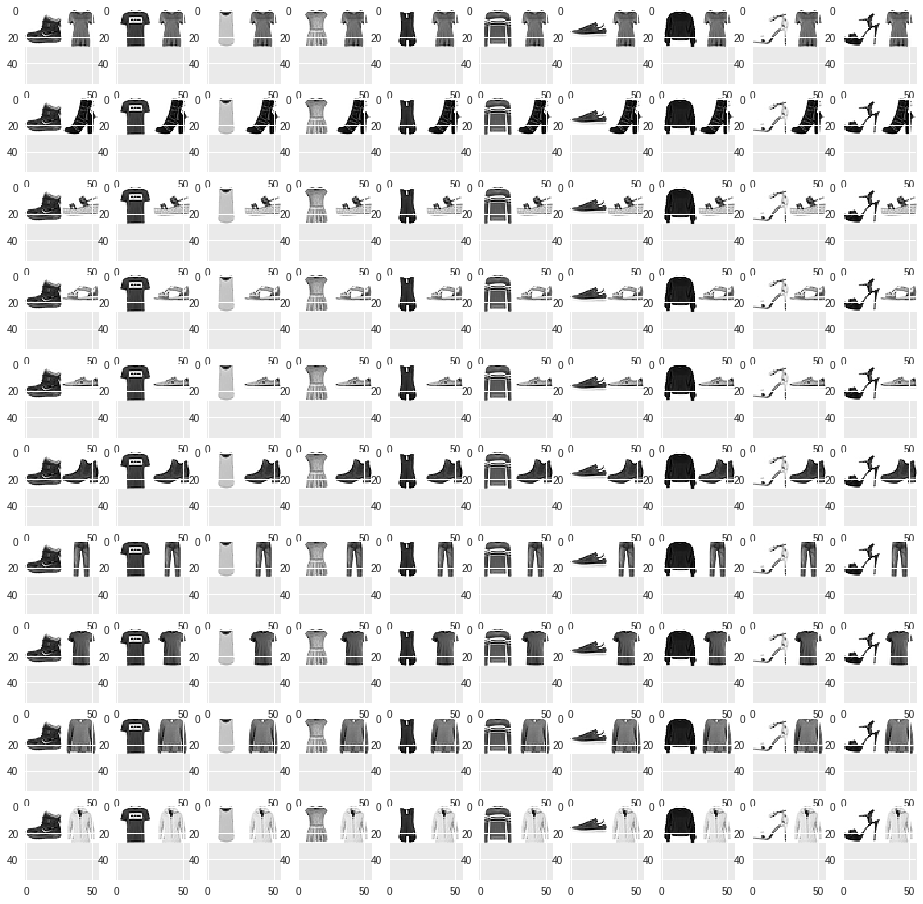

(60000, 28, 28)
(10000, 56, 56)


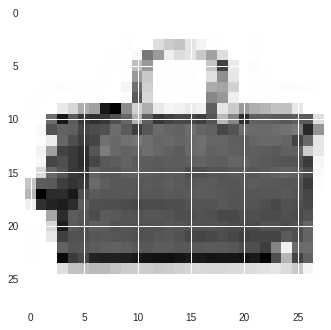

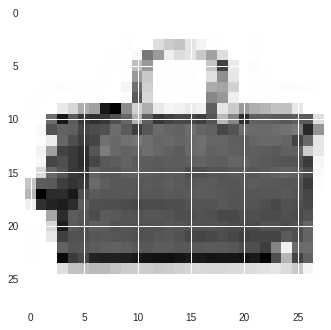

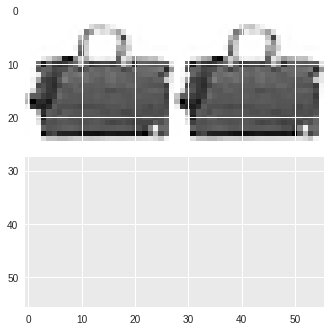

In [4]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0]/4
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def build_models():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    real = discriminator(img)
    combined = Model(z, real)
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def main():
    generator, discriminator, combined = build_models()

    train(generator, discriminator, combined,
          epochs=1, batch_size=32, save_interval=1)
    
    
    generator.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')
    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/468 [D loss: 0.979687, acc.: 31.25%] [G loss: 0.770263]


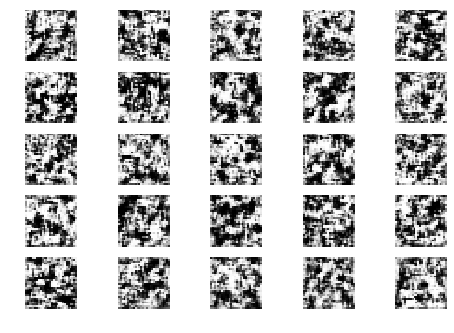

Epoch 0 Batch 1/468 [D loss: 0.706343, acc.: 62.50%] [G loss: 0.962209]
Epoch 0 Batch 2/468 [D loss: 0.534400, acc.: 78.12%] [G loss: 0.904988]
Epoch 0 Batch 3/468 [D loss: 0.517029, acc.: 81.25%] [G loss: 1.022309]
Epoch 0 Batch 4/468 [D loss: 0.352751, acc.: 87.50%] [G loss: 1.039442]
Epoch 0 Batch 5/468 [D loss: 0.385030, acc.: 87.50%] [G loss: 1.349680]
Epoch 0 Batch 6/468 [D loss: 0.352988, acc.: 87.50%] [G loss: 1.240057]
Epoch 0 Batch 7/468 [D loss: 0.306299, acc.: 100.00%] [G loss: 1.587613]
Epoch 0 Batch 8/468 [D loss: 0.292270, acc.: 96.88%] [G loss: 1.537395]
Epoch 0 Batch 9/468 [D loss: 0.259366, acc.: 90.62%] [G loss: 1.707929]
Epoch 0 Batch 10/468 [D loss: 0.304985, acc.: 90.62%] [G loss: 1.773801]
Epoch 0 Batch 11/468 [D loss: 0.289456, acc.: 90.62%] [G loss: 1.848620]
Epoch 0 Batch 12/468 [D loss: 0.212592, acc.: 96.88%] [G loss: 2.117867]
Epoch 0 Batch 13/468 [D loss: 0.229753, acc.: 93.75%] [G loss: 1.584350]
Epoch 0 Batch 14/468 [D loss: 0.194425, acc.: 96.88%] [G lo

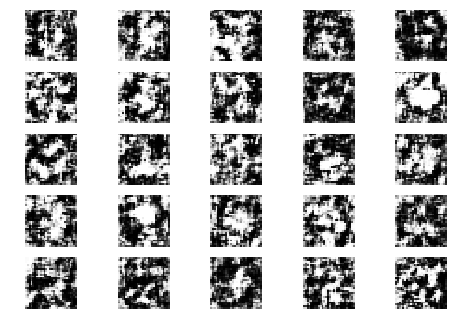

Epoch 0 Batch 51/468 [D loss: 0.030226, acc.: 100.00%] [G loss: 3.886689]
Epoch 0 Batch 52/468 [D loss: 0.035833, acc.: 100.00%] [G loss: 4.302640]
Epoch 0 Batch 53/468 [D loss: 0.032380, acc.: 100.00%] [G loss: 4.082101]
Epoch 0 Batch 54/468 [D loss: 0.034775, acc.: 100.00%] [G loss: 4.093544]
Epoch 0 Batch 55/468 [D loss: 0.034045, acc.: 100.00%] [G loss: 3.904851]
Epoch 0 Batch 56/468 [D loss: 0.096108, acc.: 93.75%] [G loss: 3.327942]
Epoch 0 Batch 57/468 [D loss: 0.077215, acc.: 96.88%] [G loss: 3.261925]
Epoch 0 Batch 58/468 [D loss: 0.135971, acc.: 96.88%] [G loss: 3.638597]
Epoch 0 Batch 59/468 [D loss: 0.030585, acc.: 100.00%] [G loss: 4.060714]
Epoch 0 Batch 60/468 [D loss: 0.074848, acc.: 100.00%] [G loss: 4.421006]
Epoch 0 Batch 61/468 [D loss: 0.061519, acc.: 100.00%] [G loss: 4.034324]
Epoch 0 Batch 62/468 [D loss: 0.018135, acc.: 100.00%] [G loss: 4.138673]
Epoch 0 Batch 63/468 [D loss: 0.017970, acc.: 100.00%] [G loss: 3.927249]
Epoch 0 Batch 64/468 [D loss: 0.075635, a

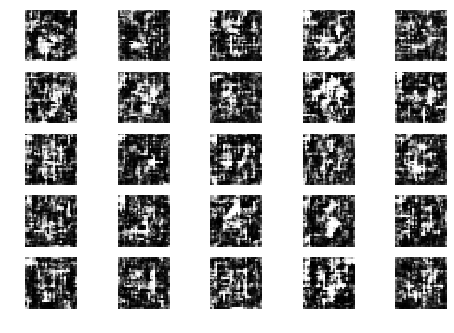

Epoch 0 Batch 101/468 [D loss: 0.067803, acc.: 100.00%] [G loss: 4.229701]
Epoch 0 Batch 102/468 [D loss: 0.046189, acc.: 100.00%] [G loss: 3.472684]
Epoch 0 Batch 103/468 [D loss: 0.069481, acc.: 96.88%] [G loss: 4.372362]
Epoch 0 Batch 104/468 [D loss: 0.112004, acc.: 96.88%] [G loss: 4.953505]
Epoch 0 Batch 105/468 [D loss: 0.052708, acc.: 100.00%] [G loss: 4.604260]
Epoch 0 Batch 106/468 [D loss: 0.029040, acc.: 100.00%] [G loss: 4.503840]
Epoch 0 Batch 107/468 [D loss: 0.061834, acc.: 96.88%] [G loss: 4.939473]
Epoch 0 Batch 108/468 [D loss: 0.067821, acc.: 100.00%] [G loss: 3.691613]
Epoch 0 Batch 109/468 [D loss: 0.063759, acc.: 96.88%] [G loss: 5.057752]
Epoch 0 Batch 110/468 [D loss: 0.024878, acc.: 100.00%] [G loss: 5.606281]
Epoch 0 Batch 111/468 [D loss: 0.083150, acc.: 96.88%] [G loss: 2.360827]
Epoch 0 Batch 112/468 [D loss: 0.106886, acc.: 96.88%] [G loss: 4.277498]
Epoch 0 Batch 113/468 [D loss: 0.034017, acc.: 100.00%] [G loss: 5.584676]
Epoch 0 Batch 114/468 [D loss: 

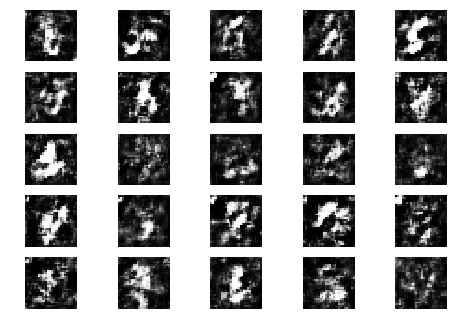

Epoch 0 Batch 151/468 [D loss: 1.357554, acc.: 34.38%] [G loss: 2.914289]
Epoch 0 Batch 152/468 [D loss: 0.392747, acc.: 78.12%] [G loss: 3.392231]
Epoch 0 Batch 153/468 [D loss: 0.949067, acc.: 46.88%] [G loss: 1.859791]
Epoch 0 Batch 154/468 [D loss: 0.685397, acc.: 56.25%] [G loss: 2.280083]
Epoch 0 Batch 155/468 [D loss: 0.267711, acc.: 90.62%] [G loss: 3.420030]
Epoch 0 Batch 156/468 [D loss: 1.072162, acc.: 37.50%] [G loss: 3.498605]
Epoch 0 Batch 157/468 [D loss: 0.412651, acc.: 81.25%] [G loss: 3.055136]
Epoch 0 Batch 158/468 [D loss: 0.882351, acc.: 56.25%] [G loss: 2.153536]
Epoch 0 Batch 159/468 [D loss: 0.361879, acc.: 81.25%] [G loss: 3.016642]
Epoch 0 Batch 160/468 [D loss: 0.819607, acc.: 56.25%] [G loss: 2.144959]
Epoch 0 Batch 161/468 [D loss: 0.777180, acc.: 56.25%] [G loss: 2.152205]
Epoch 0 Batch 162/468 [D loss: 0.804678, acc.: 62.50%] [G loss: 2.813425]
Epoch 0 Batch 163/468 [D loss: 0.864723, acc.: 59.38%] [G loss: 2.439787]
Epoch 0 Batch 164/468 [D loss: 1.15335

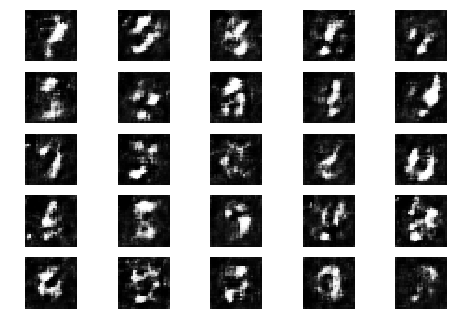

Epoch 0 Batch 201/468 [D loss: 0.326003, acc.: 87.50%] [G loss: 2.542881]
Epoch 0 Batch 202/468 [D loss: 0.966743, acc.: 46.88%] [G loss: 1.201662]
Epoch 0 Batch 203/468 [D loss: 0.609700, acc.: 68.75%] [G loss: 2.215725]
Epoch 0 Batch 204/468 [D loss: 0.510351, acc.: 78.12%] [G loss: 2.010041]
Epoch 0 Batch 205/468 [D loss: 0.616501, acc.: 71.88%] [G loss: 1.783334]
Epoch 0 Batch 206/468 [D loss: 0.961603, acc.: 50.00%] [G loss: 2.295992]
Epoch 0 Batch 207/468 [D loss: 0.650743, acc.: 75.00%] [G loss: 1.822196]
Epoch 0 Batch 208/468 [D loss: 0.771945, acc.: 59.38%] [G loss: 1.735535]
Epoch 0 Batch 209/468 [D loss: 0.898169, acc.: 56.25%] [G loss: 2.739466]
Epoch 0 Batch 210/468 [D loss: 0.873447, acc.: 50.00%] [G loss: 2.070552]
Epoch 0 Batch 211/468 [D loss: 0.689855, acc.: 68.75%] [G loss: 2.714325]
Epoch 0 Batch 212/468 [D loss: 0.612699, acc.: 56.25%] [G loss: 2.290365]
Epoch 0 Batch 213/468 [D loss: 0.690217, acc.: 68.75%] [G loss: 1.363782]
Epoch 0 Batch 214/468 [D loss: 0.60022

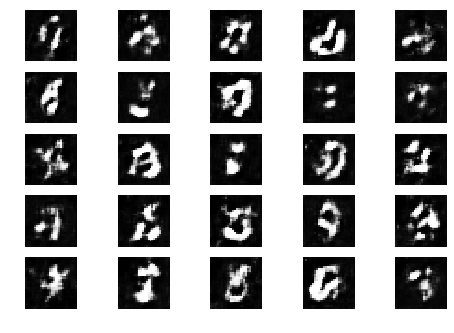

Epoch 0 Batch 251/468 [D loss: 0.825745, acc.: 59.38%] [G loss: 1.574410]
Epoch 0 Batch 252/468 [D loss: 0.999645, acc.: 40.62%] [G loss: 1.459875]
Epoch 0 Batch 253/468 [D loss: 0.722382, acc.: 65.62%] [G loss: 1.652449]
Epoch 0 Batch 254/468 [D loss: 0.642287, acc.: 65.62%] [G loss: 1.636091]
Epoch 0 Batch 255/468 [D loss: 0.559299, acc.: 71.88%] [G loss: 1.430085]
Epoch 0 Batch 256/468 [D loss: 0.708448, acc.: 62.50%] [G loss: 1.711168]
Epoch 0 Batch 257/468 [D loss: 0.437514, acc.: 75.00%] [G loss: 1.858397]
Epoch 0 Batch 258/468 [D loss: 0.616668, acc.: 75.00%] [G loss: 1.549105]
Epoch 0 Batch 259/468 [D loss: 0.510903, acc.: 81.25%] [G loss: 1.456610]
Epoch 0 Batch 260/468 [D loss: 0.508675, acc.: 68.75%] [G loss: 1.623467]
Epoch 0 Batch 261/468 [D loss: 0.868998, acc.: 53.12%] [G loss: 2.198634]
Epoch 0 Batch 262/468 [D loss: 1.077807, acc.: 34.38%] [G loss: 1.842546]
Epoch 0 Batch 263/468 [D loss: 0.691149, acc.: 78.12%] [G loss: 1.818911]
Epoch 0 Batch 264/468 [D loss: 0.37532

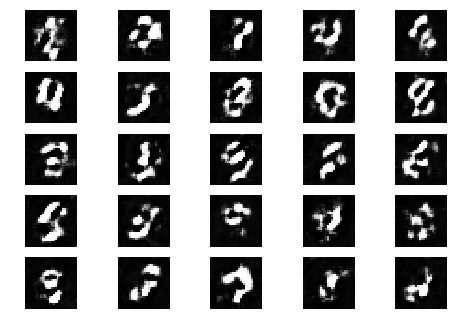

Epoch 0 Batch 301/468 [D loss: 0.489852, acc.: 75.00%] [G loss: 1.740808]
Epoch 0 Batch 302/468 [D loss: 0.866717, acc.: 53.12%] [G loss: 1.335806]
Epoch 0 Batch 303/468 [D loss: 0.624627, acc.: 71.88%] [G loss: 1.600097]
Epoch 0 Batch 304/468 [D loss: 0.737753, acc.: 59.38%] [G loss: 1.468099]
Epoch 0 Batch 305/468 [D loss: 0.721247, acc.: 65.62%] [G loss: 1.416351]
Epoch 0 Batch 306/468 [D loss: 0.786454, acc.: 53.12%] [G loss: 1.687009]
Epoch 0 Batch 307/468 [D loss: 0.525689, acc.: 68.75%] [G loss: 1.967476]
Epoch 0 Batch 308/468 [D loss: 0.642064, acc.: 68.75%] [G loss: 1.589323]
Epoch 0 Batch 309/468 [D loss: 0.584256, acc.: 65.62%] [G loss: 1.370215]
Epoch 0 Batch 310/468 [D loss: 0.833266, acc.: 50.00%] [G loss: 1.457964]
Epoch 0 Batch 311/468 [D loss: 0.797264, acc.: 50.00%] [G loss: 1.994632]
Epoch 0 Batch 312/468 [D loss: 0.439998, acc.: 81.25%] [G loss: 1.826807]
Epoch 0 Batch 313/468 [D loss: 1.202349, acc.: 43.75%] [G loss: 1.607042]
Epoch 0 Batch 314/468 [D loss: 0.76096

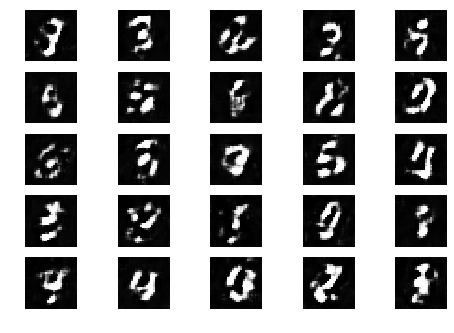

Epoch 0 Batch 351/468 [D loss: 0.785493, acc.: 56.25%] [G loss: 1.493144]
Epoch 0 Batch 352/468 [D loss: 0.790481, acc.: 53.12%] [G loss: 0.979743]
Epoch 0 Batch 353/468 [D loss: 0.779242, acc.: 56.25%] [G loss: 1.303618]
Epoch 0 Batch 354/468 [D loss: 1.069754, acc.: 43.75%] [G loss: 1.497640]
Epoch 0 Batch 355/468 [D loss: 0.822020, acc.: 62.50%] [G loss: 2.179991]
Epoch 0 Batch 356/468 [D loss: 0.922762, acc.: 50.00%] [G loss: 1.220589]
Epoch 0 Batch 357/468 [D loss: 1.005615, acc.: 37.50%] [G loss: 1.358191]
Epoch 0 Batch 358/468 [D loss: 0.533918, acc.: 75.00%] [G loss: 1.399303]
Epoch 0 Batch 359/468 [D loss: 0.885533, acc.: 46.88%] [G loss: 1.250339]
Epoch 0 Batch 360/468 [D loss: 0.567280, acc.: 75.00%] [G loss: 1.983834]
Epoch 0 Batch 361/468 [D loss: 0.689760, acc.: 50.00%] [G loss: 1.327960]
Epoch 0 Batch 362/468 [D loss: 0.753332, acc.: 59.38%] [G loss: 1.293458]
Epoch 0 Batch 363/468 [D loss: 0.456923, acc.: 84.38%] [G loss: 1.456488]
Epoch 0 Batch 364/468 [D loss: 0.87861

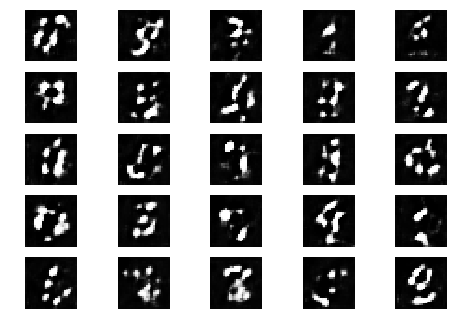

Epoch 0 Batch 401/468 [D loss: 0.598545, acc.: 75.00%] [G loss: 1.194090]
Epoch 0 Batch 402/468 [D loss: 0.639441, acc.: 68.75%] [G loss: 0.749952]
Epoch 0 Batch 403/468 [D loss: 0.929474, acc.: 53.12%] [G loss: 1.176897]
Epoch 0 Batch 404/468 [D loss: 0.653009, acc.: 56.25%] [G loss: 1.580241]
Epoch 0 Batch 405/468 [D loss: 1.002417, acc.: 40.62%] [G loss: 1.844728]
Epoch 0 Batch 406/468 [D loss: 0.685895, acc.: 53.12%] [G loss: 1.497198]
Epoch 0 Batch 407/468 [D loss: 0.822373, acc.: 50.00%] [G loss: 1.515935]
Epoch 0 Batch 408/468 [D loss: 0.632490, acc.: 71.88%] [G loss: 1.296323]
Epoch 0 Batch 409/468 [D loss: 0.462173, acc.: 75.00%] [G loss: 1.362238]
Epoch 0 Batch 410/468 [D loss: 0.631974, acc.: 65.62%] [G loss: 1.105742]
Epoch 0 Batch 411/468 [D loss: 0.707763, acc.: 71.88%] [G loss: 1.194752]
Epoch 0 Batch 412/468 [D loss: 0.938655, acc.: 56.25%] [G loss: 1.002842]
Epoch 0 Batch 413/468 [D loss: 0.653273, acc.: 65.62%] [G loss: 1.074412]
Epoch 0 Batch 414/468 [D loss: 0.81217

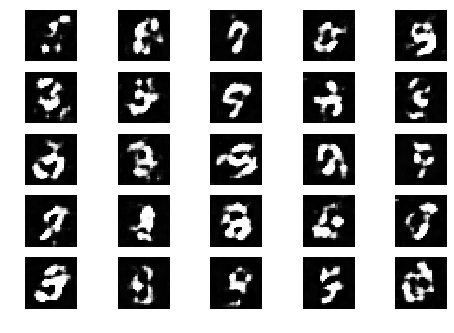

Epoch 0 Batch 451/468 [D loss: 0.612763, acc.: 59.38%] [G loss: 1.315529]
Epoch 0 Batch 452/468 [D loss: 1.015631, acc.: 25.00%] [G loss: 0.839774]
Epoch 0 Batch 453/468 [D loss: 0.773233, acc.: 65.62%] [G loss: 1.294349]
Epoch 0 Batch 454/468 [D loss: 0.390386, acc.: 81.25%] [G loss: 1.763253]
Epoch 0 Batch 455/468 [D loss: 1.017371, acc.: 37.50%] [G loss: 0.961711]
Epoch 0 Batch 456/468 [D loss: 0.807694, acc.: 59.38%] [G loss: 1.340650]
Epoch 0 Batch 457/468 [D loss: 0.524848, acc.: 68.75%] [G loss: 1.393133]
Epoch 0 Batch 458/468 [D loss: 0.640229, acc.: 62.50%] [G loss: 1.562429]
Epoch 0 Batch 459/468 [D loss: 0.698752, acc.: 53.12%] [G loss: 1.112442]
Epoch 0 Batch 460/468 [D loss: 0.768253, acc.: 65.62%] [G loss: 1.060506]
Epoch 0 Batch 461/468 [D loss: 0.632785, acc.: 65.62%] [G loss: 1.563824]
Epoch 0 Batch 462/468 [D loss: 0.478630, acc.: 78.12%] [G loss: 1.467328]
Epoch 0 Batch 463/468 [D loss: 0.601759, acc.: 62.50%] [G loss: 1.094102]
Epoch 0 Batch 464/468 [D loss: 0.59358

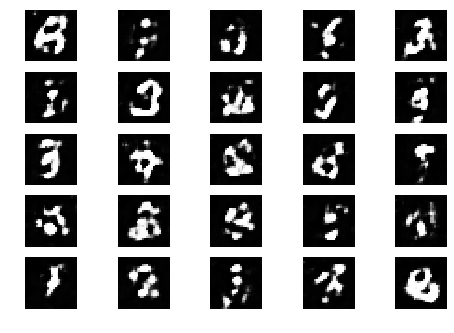

Epoch 1 Batch 1/468 [D loss: 0.483224, acc.: 75.00%] [G loss: 1.396501]
Epoch 1 Batch 2/468 [D loss: 0.461338, acc.: 81.25%] [G loss: 1.376275]
Epoch 1 Batch 3/468 [D loss: 0.585401, acc.: 62.50%] [G loss: 1.086587]
Epoch 1 Batch 4/468 [D loss: 0.584618, acc.: 75.00%] [G loss: 1.579319]
Epoch 1 Batch 5/468 [D loss: 0.526073, acc.: 75.00%] [G loss: 1.940632]
Epoch 1 Batch 6/468 [D loss: 0.751439, acc.: 46.88%] [G loss: 1.875137]
Epoch 1 Batch 7/468 [D loss: 0.625351, acc.: 59.38%] [G loss: 1.166642]
Epoch 1 Batch 8/468 [D loss: 0.871930, acc.: 40.62%] [G loss: 1.331315]
Epoch 1 Batch 9/468 [D loss: 0.598424, acc.: 65.62%] [G loss: 1.601492]
Epoch 1 Batch 10/468 [D loss: 0.565913, acc.: 65.62%] [G loss: 1.452139]
Epoch 1 Batch 11/468 [D loss: 0.857577, acc.: 46.88%] [G loss: 1.298579]
Epoch 1 Batch 12/468 [D loss: 0.580568, acc.: 71.88%] [G loss: 1.589515]
Epoch 1 Batch 13/468 [D loss: 0.531406, acc.: 68.75%] [G loss: 1.740410]
Epoch 1 Batch 14/468 [D loss: 0.767077, acc.: 59.38%] [G los

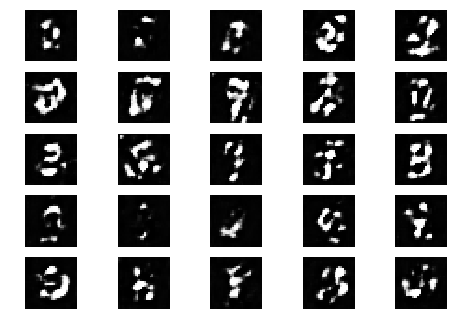

Epoch 1 Batch 51/468 [D loss: 0.683238, acc.: 62.50%] [G loss: 1.369282]
Epoch 1 Batch 52/468 [D loss: 0.687068, acc.: 56.25%] [G loss: 1.703337]
Epoch 1 Batch 53/468 [D loss: 0.453057, acc.: 78.12%] [G loss: 1.826147]
Epoch 1 Batch 54/468 [D loss: 0.687732, acc.: 65.62%] [G loss: 1.361907]
Epoch 1 Batch 55/468 [D loss: 0.863000, acc.: 40.62%] [G loss: 0.963201]
Epoch 1 Batch 56/468 [D loss: 0.834259, acc.: 59.38%] [G loss: 1.202660]
Epoch 1 Batch 57/468 [D loss: 0.496948, acc.: 78.12%] [G loss: 1.619175]
Epoch 1 Batch 58/468 [D loss: 0.592952, acc.: 71.88%] [G loss: 1.353987]
Epoch 1 Batch 59/468 [D loss: 0.558649, acc.: 75.00%] [G loss: 1.498887]
Epoch 1 Batch 60/468 [D loss: 0.803112, acc.: 46.88%] [G loss: 1.181529]
Epoch 1 Batch 61/468 [D loss: 0.551203, acc.: 68.75%] [G loss: 1.518241]
Epoch 1 Batch 62/468 [D loss: 0.626453, acc.: 65.62%] [G loss: 1.483669]
Epoch 1 Batch 63/468 [D loss: 0.467130, acc.: 78.12%] [G loss: 1.721591]
Epoch 1 Batch 64/468 [D loss: 0.805868, acc.: 46.88

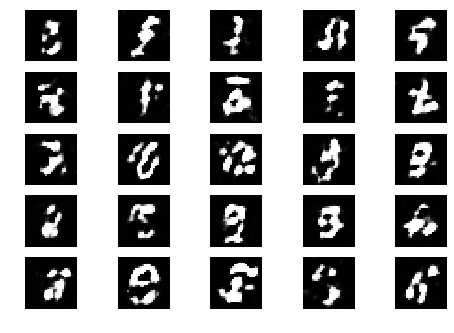

Epoch 1 Batch 101/468 [D loss: 0.643318, acc.: 62.50%] [G loss: 1.449008]
Epoch 1 Batch 102/468 [D loss: 0.675058, acc.: 59.38%] [G loss: 1.411076]
Epoch 1 Batch 103/468 [D loss: 0.581447, acc.: 65.62%] [G loss: 1.743170]
Epoch 1 Batch 104/468 [D loss: 0.950205, acc.: 46.88%] [G loss: 1.248056]
Epoch 1 Batch 105/468 [D loss: 0.538452, acc.: 68.75%] [G loss: 1.743955]
Epoch 1 Batch 106/468 [D loss: 0.747283, acc.: 65.62%] [G loss: 1.760672]
Epoch 1 Batch 107/468 [D loss: 0.628096, acc.: 68.75%] [G loss: 0.976944]
Epoch 1 Batch 108/468 [D loss: 0.714623, acc.: 53.12%] [G loss: 1.073454]
Epoch 1 Batch 109/468 [D loss: 0.528060, acc.: 75.00%] [G loss: 1.377409]
Epoch 1 Batch 110/468 [D loss: 0.731679, acc.: 59.38%] [G loss: 1.502220]
Epoch 1 Batch 111/468 [D loss: 0.330035, acc.: 90.62%] [G loss: 1.611602]
Epoch 1 Batch 112/468 [D loss: 0.899178, acc.: 53.12%] [G loss: 1.331857]
Epoch 1 Batch 113/468 [D loss: 0.615264, acc.: 71.88%] [G loss: 0.959616]
Epoch 1 Batch 114/468 [D loss: 0.86371

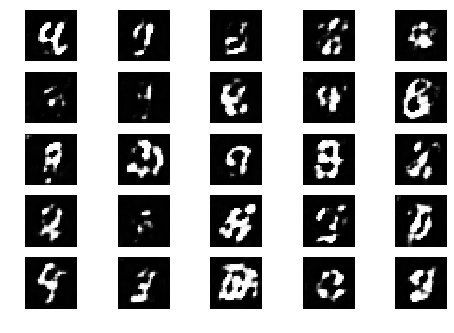

Epoch 1 Batch 151/468 [D loss: 0.784252, acc.: 50.00%] [G loss: 1.341090]
Epoch 1 Batch 152/468 [D loss: 0.478948, acc.: 81.25%] [G loss: 1.732967]
Epoch 1 Batch 153/468 [D loss: 0.597495, acc.: 68.75%] [G loss: 1.486727]
Epoch 1 Batch 154/468 [D loss: 0.764837, acc.: 53.12%] [G loss: 1.346020]
Epoch 1 Batch 155/468 [D loss: 0.697452, acc.: 65.62%] [G loss: 1.494975]
Epoch 1 Batch 156/468 [D loss: 0.674335, acc.: 59.38%] [G loss: 1.698337]
Epoch 1 Batch 157/468 [D loss: 0.760700, acc.: 62.50%] [G loss: 1.663316]
Epoch 1 Batch 158/468 [D loss: 0.575384, acc.: 68.75%] [G loss: 1.391063]
Epoch 1 Batch 159/468 [D loss: 0.723350, acc.: 56.25%] [G loss: 1.192343]
Epoch 1 Batch 160/468 [D loss: 0.638981, acc.: 68.75%] [G loss: 1.350463]
Epoch 1 Batch 161/468 [D loss: 0.781463, acc.: 53.12%] [G loss: 1.337712]
Epoch 1 Batch 162/468 [D loss: 0.581309, acc.: 68.75%] [G loss: 1.348093]
Epoch 1 Batch 163/468 [D loss: 0.674649, acc.: 59.38%] [G loss: 1.491757]
Epoch 1 Batch 164/468 [D loss: 0.49760

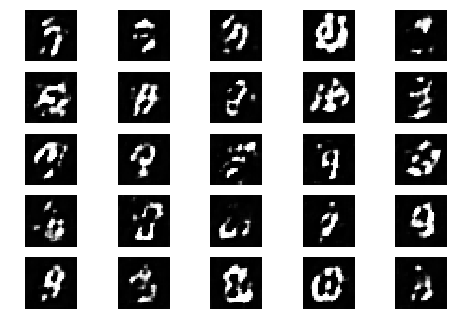

Epoch 1 Batch 201/468 [D loss: 0.804527, acc.: 43.75%] [G loss: 1.306525]
Epoch 1 Batch 202/468 [D loss: 0.458228, acc.: 78.12%] [G loss: 1.836533]
Epoch 1 Batch 203/468 [D loss: 0.638896, acc.: 59.38%] [G loss: 1.347551]
Epoch 1 Batch 204/468 [D loss: 0.444107, acc.: 78.12%] [G loss: 1.399499]
Epoch 1 Batch 205/468 [D loss: 0.510481, acc.: 75.00%] [G loss: 1.675461]
Epoch 1 Batch 206/468 [D loss: 0.567616, acc.: 68.75%] [G loss: 1.361673]
Epoch 1 Batch 207/468 [D loss: 0.666484, acc.: 62.50%] [G loss: 1.648097]
Epoch 1 Batch 208/468 [D loss: 0.830759, acc.: 50.00%] [G loss: 0.974393]
Epoch 1 Batch 209/468 [D loss: 0.500907, acc.: 81.25%] [G loss: 1.231180]
Epoch 1 Batch 210/468 [D loss: 0.704574, acc.: 75.00%] [G loss: 1.441507]
Epoch 1 Batch 211/468 [D loss: 0.573216, acc.: 68.75%] [G loss: 1.600300]
Epoch 1 Batch 212/468 [D loss: 0.685207, acc.: 65.62%] [G loss: 1.473942]
Epoch 1 Batch 213/468 [D loss: 0.491776, acc.: 84.38%] [G loss: 1.728059]
Epoch 1 Batch 214/468 [D loss: 0.80824

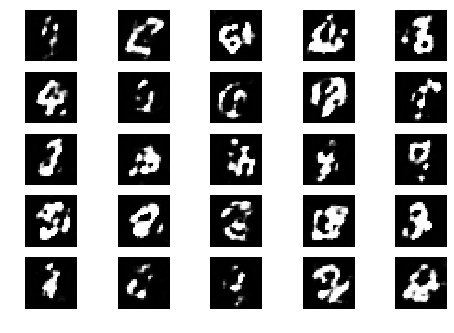

Epoch 1 Batch 251/468 [D loss: 0.408874, acc.: 84.38%] [G loss: 1.516146]
Epoch 1 Batch 252/468 [D loss: 0.399487, acc.: 81.25%] [G loss: 1.416834]
Epoch 1 Batch 253/468 [D loss: 0.615979, acc.: 59.38%] [G loss: 1.139459]
Epoch 1 Batch 254/468 [D loss: 0.372398, acc.: 87.50%] [G loss: 1.407756]
Epoch 1 Batch 255/468 [D loss: 0.276147, acc.: 90.62%] [G loss: 2.154624]
Epoch 1 Batch 256/468 [D loss: 0.532391, acc.: 71.88%] [G loss: 1.158817]
Epoch 1 Batch 257/468 [D loss: 0.461438, acc.: 81.25%] [G loss: 2.269893]
Epoch 1 Batch 258/468 [D loss: 0.474087, acc.: 75.00%] [G loss: 2.124596]
Epoch 1 Batch 259/468 [D loss: 0.875376, acc.: 53.12%] [G loss: 1.167880]
Epoch 1 Batch 260/468 [D loss: 0.608722, acc.: 65.62%] [G loss: 1.530875]
Epoch 1 Batch 261/468 [D loss: 0.410319, acc.: 87.50%] [G loss: 2.158725]
Epoch 1 Batch 262/468 [D loss: 0.707706, acc.: 59.38%] [G loss: 1.589069]
Epoch 1 Batch 263/468 [D loss: 0.532627, acc.: 65.62%] [G loss: 1.067496]
Epoch 1 Batch 264/468 [D loss: 0.62215

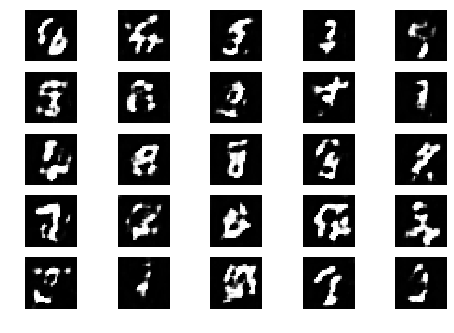

Epoch 1 Batch 301/468 [D loss: 0.654330, acc.: 56.25%] [G loss: 1.454943]
Epoch 1 Batch 302/468 [D loss: 0.288709, acc.: 96.88%] [G loss: 1.497725]
Epoch 1 Batch 303/468 [D loss: 0.878806, acc.: 46.88%] [G loss: 1.321559]
Epoch 1 Batch 304/468 [D loss: 0.523552, acc.: 78.12%] [G loss: 1.651468]
Epoch 1 Batch 305/468 [D loss: 0.561690, acc.: 75.00%] [G loss: 1.348763]
Epoch 1 Batch 306/468 [D loss: 0.655526, acc.: 56.25%] [G loss: 1.060660]
Epoch 1 Batch 307/468 [D loss: 0.493454, acc.: 78.12%] [G loss: 1.611965]
Epoch 1 Batch 308/468 [D loss: 0.521449, acc.: 78.12%] [G loss: 1.634841]
Epoch 1 Batch 309/468 [D loss: 0.533580, acc.: 68.75%] [G loss: 1.283194]
Epoch 1 Batch 310/468 [D loss: 0.556050, acc.: 62.50%] [G loss: 1.652948]
Epoch 1 Batch 311/468 [D loss: 0.497872, acc.: 75.00%] [G loss: 1.672142]
Epoch 1 Batch 312/468 [D loss: 0.618056, acc.: 65.62%] [G loss: 1.528338]
Epoch 1 Batch 313/468 [D loss: 1.032951, acc.: 31.25%] [G loss: 1.026641]
Epoch 1 Batch 314/468 [D loss: 0.64405

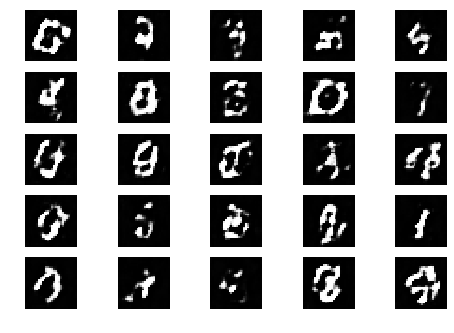

Epoch 1 Batch 351/468 [D loss: 0.767969, acc.: 59.38%] [G loss: 1.364558]
Epoch 1 Batch 352/468 [D loss: 0.280910, acc.: 93.75%] [G loss: 1.512330]
Epoch 1 Batch 353/468 [D loss: 0.594536, acc.: 59.38%] [G loss: 1.628922]
Epoch 1 Batch 354/468 [D loss: 0.718360, acc.: 62.50%] [G loss: 1.470220]
Epoch 1 Batch 355/468 [D loss: 0.402905, acc.: 84.38%] [G loss: 1.565806]
Epoch 1 Batch 356/468 [D loss: 0.452603, acc.: 84.38%] [G loss: 1.617928]
Epoch 1 Batch 357/468 [D loss: 0.461125, acc.: 84.38%] [G loss: 2.100035]
Epoch 1 Batch 358/468 [D loss: 0.451348, acc.: 78.12%] [G loss: 1.973548]
Epoch 1 Batch 359/468 [D loss: 0.589473, acc.: 71.88%] [G loss: 1.431654]
Epoch 1 Batch 360/468 [D loss: 0.824157, acc.: 46.88%] [G loss: 1.392944]
Epoch 1 Batch 361/468 [D loss: 0.599544, acc.: 71.88%] [G loss: 1.219728]
Epoch 1 Batch 362/468 [D loss: 0.721865, acc.: 56.25%] [G loss: 1.551450]
Epoch 1 Batch 363/468 [D loss: 0.693321, acc.: 71.88%] [G loss: 1.299054]
Epoch 1 Batch 364/468 [D loss: 0.55269

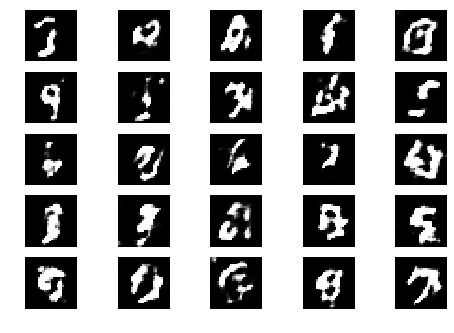

Epoch 1 Batch 401/468 [D loss: 0.383033, acc.: 81.25%] [G loss: 1.773254]
Epoch 1 Batch 402/468 [D loss: 0.336897, acc.: 93.75%] [G loss: 1.720525]
Epoch 1 Batch 403/468 [D loss: 0.532035, acc.: 71.88%] [G loss: 1.588048]
Epoch 1 Batch 404/468 [D loss: 0.570365, acc.: 75.00%] [G loss: 1.507858]
Epoch 1 Batch 405/468 [D loss: 0.484780, acc.: 75.00%] [G loss: 1.591407]
Epoch 1 Batch 406/468 [D loss: 0.433005, acc.: 90.62%] [G loss: 1.888984]
Epoch 1 Batch 407/468 [D loss: 1.160727, acc.: 31.25%] [G loss: 1.354901]
Epoch 1 Batch 408/468 [D loss: 0.499354, acc.: 65.62%] [G loss: 1.435461]
Epoch 1 Batch 409/468 [D loss: 0.543749, acc.: 65.62%] [G loss: 1.701083]
Epoch 1 Batch 410/468 [D loss: 0.638704, acc.: 56.25%] [G loss: 1.607331]
Epoch 1 Batch 411/468 [D loss: 0.233668, acc.: 93.75%] [G loss: 1.279543]
Epoch 1 Batch 412/468 [D loss: 0.554206, acc.: 75.00%] [G loss: 1.324533]
Epoch 1 Batch 413/468 [D loss: 0.876808, acc.: 56.25%] [G loss: 1.787639]
Epoch 1 Batch 414/468 [D loss: 0.70246

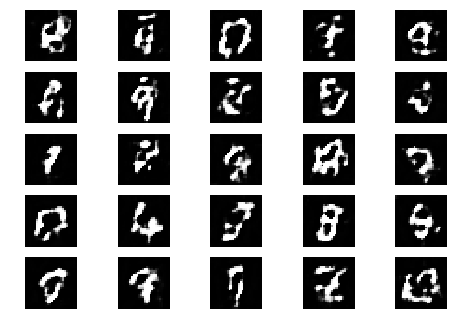

Epoch 1 Batch 451/468 [D loss: 0.437882, acc.: 78.12%] [G loss: 1.722984]
Epoch 1 Batch 452/468 [D loss: 0.665615, acc.: 62.50%] [G loss: 1.308199]
Epoch 1 Batch 453/468 [D loss: 0.493349, acc.: 78.12%] [G loss: 1.856485]
Epoch 1 Batch 454/468 [D loss: 0.745555, acc.: 50.00%] [G loss: 2.131757]
Epoch 1 Batch 455/468 [D loss: 0.766117, acc.: 62.50%] [G loss: 1.202017]
Epoch 1 Batch 456/468 [D loss: 0.802805, acc.: 46.88%] [G loss: 1.214722]
Epoch 1 Batch 457/468 [D loss: 0.146632, acc.: 100.00%] [G loss: 1.587741]
Epoch 1 Batch 458/468 [D loss: 0.323265, acc.: 90.62%] [G loss: 1.573007]
Epoch 1 Batch 459/468 [D loss: 0.596170, acc.: 75.00%] [G loss: 1.115651]
Epoch 1 Batch 460/468 [D loss: 0.743689, acc.: 59.38%] [G loss: 1.590998]
Epoch 1 Batch 461/468 [D loss: 0.624223, acc.: 56.25%] [G loss: 1.233979]
Epoch 1 Batch 462/468 [D loss: 0.351028, acc.: 93.75%] [G loss: 1.878724]
Epoch 1 Batch 463/468 [D loss: 0.665464, acc.: 56.25%] [G loss: 1.393881]
Epoch 1 Batch 464/468 [D loss: 0.6092

In [15]:
if __name__ == '__main__':
    main()

In [0]:
files.download('generator1.h5')

In [0]:
files.download('discriminator1.h5')

In [0]:
files.download('combined1.h5')

In [19]:
generator1 = load_model('generator1.h5')
discriminator1 = load_model('discriminator1.h5')
combined1 = load_model('combined1.h5')



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Number of examples:  15000.0
Number of Batches:  468
Number of epochs:  1
Epoch 0 Batch 0/468 [D loss: 0.569214, acc.: 71.88%] [G loss: 1.756867]


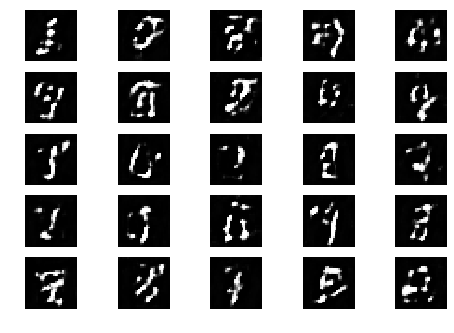

Epoch 0 Batch 1/468 [D loss: 0.492264, acc.: 71.88%] [G loss: 0.582677]
Epoch 0 Batch 2/468 [D loss: 0.528654, acc.: 65.62%] [G loss: 0.169781]
Epoch 0 Batch 3/468 [D loss: 0.530311, acc.: 71.88%] [G loss: 0.034117]
Epoch 0 Batch 4/468 [D loss: 0.488791, acc.: 75.00%] [G loss: 0.017956]
Epoch 0 Batch 5/468 [D loss: 0.632543, acc.: 68.75%] [G loss: 0.009744]
Epoch 0 Batch 6/468 [D loss: 0.175966, acc.: 96.88%] [G loss: 0.008009]
Epoch 0 Batch 7/468 [D loss: 0.231354, acc.: 93.75%] [G loss: 0.007515]
Epoch 0 Batch 8/468 [D loss: 0.161067, acc.: 96.88%] [G loss: 0.008358]
Epoch 0 Batch 9/468 [D loss: 0.576703, acc.: 65.62%] [G loss: 0.009045]
Epoch 0 Batch 10/468 [D loss: 0.205402, acc.: 96.88%] [G loss: 0.003449]
Epoch 0 Batch 11/468 [D loss: 0.325910, acc.: 84.38%] [G loss: 0.004563]
Epoch 0 Batch 12/468 [D loss: 0.269525, acc.: 90.62%] [G loss: 0.006560]
Epoch 0 Batch 13/468 [D loss: 0.183223, acc.: 90.62%] [G loss: 0.008944]
Epoch 0 Batch 14/468 [D loss: 0.294203, acc.: 87.50%] [G los

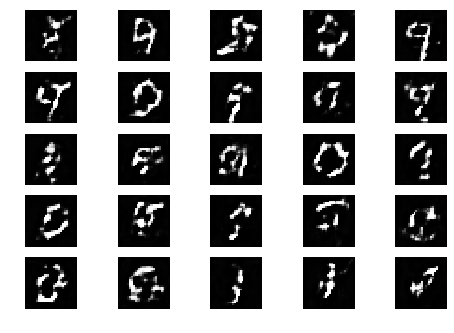

Epoch 0 Batch 51/468 [D loss: 0.058179, acc.: 100.00%] [G loss: 0.001286]
Epoch 0 Batch 52/468 [D loss: 0.189351, acc.: 93.75%] [G loss: 0.001104]
Epoch 0 Batch 53/468 [D loss: 0.056095, acc.: 100.00%] [G loss: 0.001412]
Epoch 0 Batch 54/468 [D loss: 0.220250, acc.: 90.62%] [G loss: 0.001100]
Epoch 0 Batch 55/468 [D loss: 0.162962, acc.: 93.75%] [G loss: 0.000662]
Epoch 0 Batch 56/468 [D loss: 0.117264, acc.: 96.88%] [G loss: 0.000676]
Epoch 0 Batch 57/468 [D loss: 0.080471, acc.: 96.88%] [G loss: 0.000972]
Epoch 0 Batch 58/468 [D loss: 0.056379, acc.: 96.88%] [G loss: 0.000898]
Epoch 0 Batch 59/468 [D loss: 0.071475, acc.: 100.00%] [G loss: 0.001055]
Epoch 0 Batch 60/468 [D loss: 0.170322, acc.: 96.88%] [G loss: 0.000619]
Epoch 0 Batch 61/468 [D loss: 0.042932, acc.: 100.00%] [G loss: 0.000859]
Epoch 0 Batch 62/468 [D loss: 0.105457, acc.: 100.00%] [G loss: 0.000579]
Epoch 0 Batch 63/468 [D loss: 0.099448, acc.: 100.00%] [G loss: 0.001356]
Epoch 0 Batch 64/468 [D loss: 0.148191, acc.:

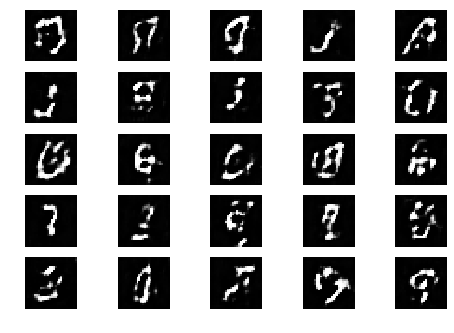

Epoch 0 Batch 101/468 [D loss: 0.029954, acc.: 100.00%] [G loss: 0.000476]
Epoch 0 Batch 102/468 [D loss: 0.011204, acc.: 100.00%] [G loss: 0.000331]
Epoch 0 Batch 103/468 [D loss: 0.067751, acc.: 100.00%] [G loss: 0.000539]
Epoch 0 Batch 104/468 [D loss: 0.014813, acc.: 100.00%] [G loss: 0.000462]
Epoch 0 Batch 105/468 [D loss: 0.013668, acc.: 100.00%] [G loss: 0.000503]
Epoch 0 Batch 106/468 [D loss: 0.012278, acc.: 100.00%] [G loss: 0.000281]
Epoch 0 Batch 107/468 [D loss: 0.046120, acc.: 100.00%] [G loss: 0.000795]
Epoch 0 Batch 108/468 [D loss: 0.065406, acc.: 96.88%] [G loss: 0.000237]
Epoch 0 Batch 109/468 [D loss: 0.034934, acc.: 100.00%] [G loss: 0.000401]
Epoch 0 Batch 110/468 [D loss: 0.035042, acc.: 100.00%] [G loss: 0.000288]
Epoch 0 Batch 111/468 [D loss: 0.063247, acc.: 100.00%] [G loss: 0.000418]
Epoch 0 Batch 112/468 [D loss: 0.046737, acc.: 100.00%] [G loss: 0.000424]
Epoch 0 Batch 113/468 [D loss: 0.026020, acc.: 100.00%] [G loss: 0.000327]
Epoch 0 Batch 114/468 [D l

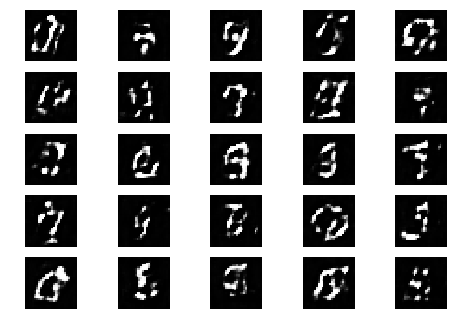

Epoch 0 Batch 151/468 [D loss: 0.021270, acc.: 100.00%] [G loss: 0.000280]
Epoch 0 Batch 152/468 [D loss: 0.020997, acc.: 100.00%] [G loss: 0.000179]
Epoch 0 Batch 153/468 [D loss: 0.065187, acc.: 100.00%] [G loss: 0.000145]
Epoch 0 Batch 154/468 [D loss: 0.025724, acc.: 100.00%] [G loss: 0.000566]
Epoch 0 Batch 155/468 [D loss: 0.081951, acc.: 96.88%] [G loss: 0.000375]
Epoch 0 Batch 156/468 [D loss: 0.089596, acc.: 96.88%] [G loss: 0.000165]
Epoch 0 Batch 157/468 [D loss: 0.055854, acc.: 100.00%] [G loss: 0.000213]
Epoch 0 Batch 158/468 [D loss: 0.005512, acc.: 100.00%] [G loss: 0.000169]
Epoch 0 Batch 159/468 [D loss: 0.068434, acc.: 96.88%] [G loss: 0.000213]
Epoch 0 Batch 160/468 [D loss: 0.013529, acc.: 100.00%] [G loss: 0.000175]
Epoch 0 Batch 161/468 [D loss: 0.011440, acc.: 100.00%] [G loss: 0.000319]
Epoch 0 Batch 162/468 [D loss: 0.004322, acc.: 100.00%] [G loss: 0.000168]
Epoch 0 Batch 163/468 [D loss: 0.003325, acc.: 100.00%] [G loss: 0.000208]
Epoch 0 Batch 164/468 [D los

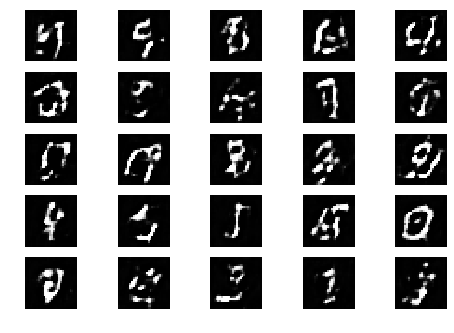

Epoch 0 Batch 201/468 [D loss: 0.074598, acc.: 100.00%] [G loss: 0.000161]
Epoch 0 Batch 202/468 [D loss: 0.057377, acc.: 96.88%] [G loss: 0.000132]
Epoch 0 Batch 203/468 [D loss: 0.010847, acc.: 100.00%] [G loss: 0.000212]
Epoch 0 Batch 204/468 [D loss: 0.006487, acc.: 100.00%] [G loss: 0.000139]
Epoch 0 Batch 205/468 [D loss: 0.027973, acc.: 100.00%] [G loss: 0.000113]
Epoch 0 Batch 206/468 [D loss: 0.032835, acc.: 100.00%] [G loss: 0.000121]
Epoch 0 Batch 207/468 [D loss: 0.001400, acc.: 100.00%] [G loss: 0.000137]
Epoch 0 Batch 208/468 [D loss: 0.011368, acc.: 100.00%] [G loss: 0.000126]
Epoch 0 Batch 209/468 [D loss: 0.019966, acc.: 100.00%] [G loss: 0.000095]
Epoch 0 Batch 210/468 [D loss: 0.103815, acc.: 96.88%] [G loss: 0.000081]
Epoch 0 Batch 211/468 [D loss: 0.006781, acc.: 100.00%] [G loss: 0.000149]
Epoch 0 Batch 212/468 [D loss: 0.014557, acc.: 100.00%] [G loss: 0.000078]
Epoch 0 Batch 213/468 [D loss: 0.007578, acc.: 100.00%] [G loss: 0.000235]
Epoch 0 Batch 214/468 [D lo

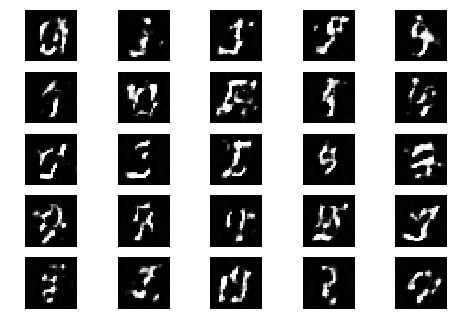

Epoch 0 Batch 251/468 [D loss: 0.001722, acc.: 100.00%] [G loss: 0.000183]
Epoch 0 Batch 252/468 [D loss: 0.002360, acc.: 100.00%] [G loss: 0.000087]
Epoch 0 Batch 253/468 [D loss: 0.067671, acc.: 100.00%] [G loss: 0.000067]
Epoch 0 Batch 254/468 [D loss: 0.001814, acc.: 100.00%] [G loss: 0.000129]
Epoch 0 Batch 255/468 [D loss: 0.001674, acc.: 100.00%] [G loss: 0.000160]
Epoch 0 Batch 256/468 [D loss: 0.129839, acc.: 90.62%] [G loss: 0.000121]
Epoch 0 Batch 257/468 [D loss: 0.022417, acc.: 100.00%] [G loss: 0.000155]
Epoch 0 Batch 258/468 [D loss: 0.012013, acc.: 100.00%] [G loss: 0.000117]
Epoch 0 Batch 259/468 [D loss: 0.004052, acc.: 100.00%] [G loss: 0.000070]
Epoch 0 Batch 260/468 [D loss: 0.050532, acc.: 96.88%] [G loss: 0.000072]
Epoch 0 Batch 261/468 [D loss: 0.013416, acc.: 100.00%] [G loss: 0.000119]
Epoch 0 Batch 262/468 [D loss: 0.005775, acc.: 100.00%] [G loss: 0.000108]
Epoch 0 Batch 263/468 [D loss: 0.019473, acc.: 100.00%] [G loss: 0.000106]
Epoch 0 Batch 264/468 [D lo

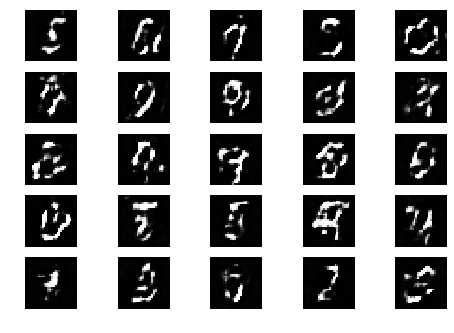

Epoch 0 Batch 301/468 [D loss: 0.000735, acc.: 100.00%] [G loss: 0.000075]
Epoch 0 Batch 302/468 [D loss: 0.000911, acc.: 100.00%] [G loss: 0.000057]
Epoch 0 Batch 303/468 [D loss: 0.010730, acc.: 100.00%] [G loss: 0.000103]
Epoch 0 Batch 304/468 [D loss: 0.019148, acc.: 100.00%] [G loss: 0.000038]
Epoch 0 Batch 305/468 [D loss: 0.009542, acc.: 100.00%] [G loss: 0.000096]
Epoch 0 Batch 306/468 [D loss: 0.005076, acc.: 100.00%] [G loss: 0.000143]
Epoch 0 Batch 307/468 [D loss: 0.038872, acc.: 100.00%] [G loss: 0.000065]
Epoch 0 Batch 308/468 [D loss: 0.011339, acc.: 100.00%] [G loss: 0.000076]
Epoch 0 Batch 309/468 [D loss: 0.002745, acc.: 100.00%] [G loss: 0.000085]
Epoch 0 Batch 310/468 [D loss: 0.096395, acc.: 96.88%] [G loss: 0.000107]
Epoch 0 Batch 311/468 [D loss: 0.033049, acc.: 100.00%] [G loss: 0.000082]
Epoch 0 Batch 312/468 [D loss: 0.004309, acc.: 100.00%] [G loss: 0.000062]
Epoch 0 Batch 313/468 [D loss: 0.002426, acc.: 100.00%] [G loss: 0.000058]
Epoch 0 Batch 314/468 [D l

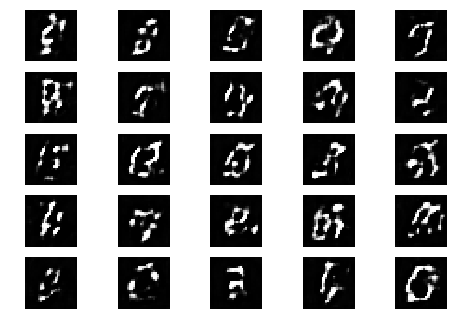

Epoch 0 Batch 351/468 [D loss: 0.001705, acc.: 100.00%] [G loss: 0.000080]
Epoch 0 Batch 352/468 [D loss: 0.005387, acc.: 100.00%] [G loss: 0.000083]
Epoch 0 Batch 353/468 [D loss: 0.009768, acc.: 100.00%] [G loss: 0.000064]
Epoch 0 Batch 354/468 [D loss: 0.000968, acc.: 100.00%] [G loss: 0.000085]
Epoch 0 Batch 355/468 [D loss: 0.009536, acc.: 100.00%] [G loss: 0.000053]
Epoch 0 Batch 356/468 [D loss: 0.002643, acc.: 100.00%] [G loss: 0.000050]
Epoch 0 Batch 357/468 [D loss: 0.001167, acc.: 100.00%] [G loss: 0.000077]
Epoch 0 Batch 358/468 [D loss: 0.011601, acc.: 100.00%] [G loss: 0.000061]
Epoch 0 Batch 359/468 [D loss: 0.004257, acc.: 100.00%] [G loss: 0.000070]
Epoch 0 Batch 360/468 [D loss: 0.000545, acc.: 100.00%] [G loss: 0.000078]
Epoch 0 Batch 361/468 [D loss: 0.002198, acc.: 100.00%] [G loss: 0.000075]
Epoch 0 Batch 362/468 [D loss: 0.042875, acc.: 100.00%] [G loss: 0.000106]
Epoch 0 Batch 363/468 [D loss: 0.006789, acc.: 100.00%] [G loss: 0.000038]
Epoch 0 Batch 364/468 [D 

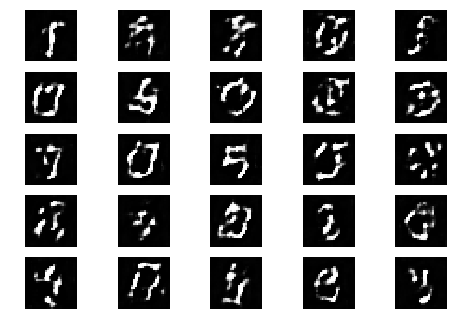

Epoch 0 Batch 401/468 [D loss: 0.000321, acc.: 100.00%] [G loss: 0.000038]
Epoch 0 Batch 402/468 [D loss: 0.102075, acc.: 96.88%] [G loss: 0.000048]
Epoch 0 Batch 403/468 [D loss: 0.001867, acc.: 100.00%] [G loss: 0.000069]
Epoch 0 Batch 404/468 [D loss: 0.049778, acc.: 96.88%] [G loss: 0.000051]
Epoch 0 Batch 405/468 [D loss: 0.008938, acc.: 100.00%] [G loss: 0.000031]
Epoch 0 Batch 406/468 [D loss: 0.000247, acc.: 100.00%] [G loss: 0.000050]
Epoch 0 Batch 407/468 [D loss: 0.001585, acc.: 100.00%] [G loss: 0.000045]
Epoch 0 Batch 408/468 [D loss: 0.006298, acc.: 100.00%] [G loss: 0.000141]
Epoch 0 Batch 409/468 [D loss: 0.000811, acc.: 100.00%] [G loss: 0.000045]
Epoch 0 Batch 410/468 [D loss: 0.002789, acc.: 100.00%] [G loss: 0.000090]
Epoch 0 Batch 411/468 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.000053]
Epoch 0 Batch 412/468 [D loss: 0.045275, acc.: 100.00%] [G loss: 0.000042]
Epoch 0 Batch 413/468 [D loss: 0.008960, acc.: 100.00%] [G loss: 0.000053]
Epoch 0 Batch 414/468 [D lo

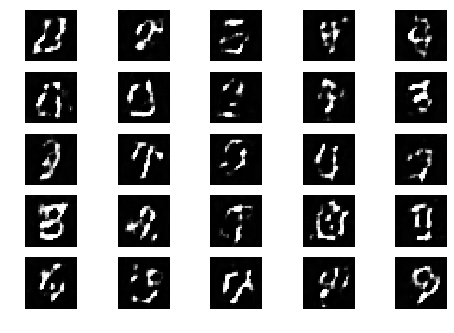

Epoch 0 Batch 451/468 [D loss: 0.039220, acc.: 100.00%] [G loss: 0.000044]
Epoch 0 Batch 452/468 [D loss: 0.001396, acc.: 100.00%] [G loss: 0.000076]
Epoch 0 Batch 453/468 [D loss: 0.000683, acc.: 100.00%] [G loss: 0.000054]
Epoch 0 Batch 454/468 [D loss: 0.001271, acc.: 100.00%] [G loss: 0.000027]
Epoch 0 Batch 455/468 [D loss: 0.000286, acc.: 100.00%] [G loss: 0.000023]
Epoch 0 Batch 456/468 [D loss: 0.018791, acc.: 100.00%] [G loss: 0.000041]
Epoch 0 Batch 457/468 [D loss: 0.000850, acc.: 100.00%] [G loss: 0.000032]
Epoch 0 Batch 458/468 [D loss: 0.000611, acc.: 100.00%] [G loss: 0.000046]
Epoch 0 Batch 459/468 [D loss: 0.000182, acc.: 100.00%] [G loss: 0.000056]
Epoch 0 Batch 460/468 [D loss: 0.000371, acc.: 100.00%] [G loss: 0.000033]
Epoch 0 Batch 461/468 [D loss: 0.000315, acc.: 100.00%] [G loss: 0.000024]
Epoch 0 Batch 462/468 [D loss: 0.000224, acc.: 100.00%] [G loss: 0.000054]
Epoch 0 Batch 463/468 [D loss: 0.001676, acc.: 100.00%] [G loss: 0.000037]
Epoch 0 Batch 464/468 [D 

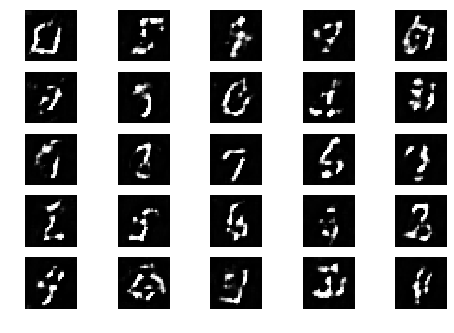

Epoch 1 Batch 1/468 [D loss: 0.000363, acc.: 100.00%] [G loss: 0.000034]
Epoch 1 Batch 2/468 [D loss: 0.000282, acc.: 100.00%] [G loss: 0.000041]
Epoch 1 Batch 3/468 [D loss: 0.000887, acc.: 100.00%] [G loss: 0.000026]
Epoch 1 Batch 4/468 [D loss: 0.001253, acc.: 100.00%] [G loss: 0.000036]
Epoch 1 Batch 5/468 [D loss: 0.006855, acc.: 100.00%] [G loss: 0.000031]
Epoch 1 Batch 6/468 [D loss: 0.007631, acc.: 100.00%] [G loss: 0.000041]
Epoch 1 Batch 7/468 [D loss: 0.001514, acc.: 100.00%] [G loss: 0.000043]
Epoch 1 Batch 8/468 [D loss: 0.000135, acc.: 100.00%] [G loss: 0.000027]
Epoch 1 Batch 9/468 [D loss: 0.001671, acc.: 100.00%] [G loss: 0.000041]
Epoch 1 Batch 10/468 [D loss: 0.000451, acc.: 100.00%] [G loss: 0.000037]
Epoch 1 Batch 11/468 [D loss: 0.002521, acc.: 100.00%] [G loss: 0.000046]
Epoch 1 Batch 12/468 [D loss: 0.003768, acc.: 100.00%] [G loss: 0.000047]
Epoch 1 Batch 13/468 [D loss: 0.005707, acc.: 100.00%] [G loss: 0.000043]
Epoch 1 Batch 14/468 [D loss: 0.002225, acc.: 1

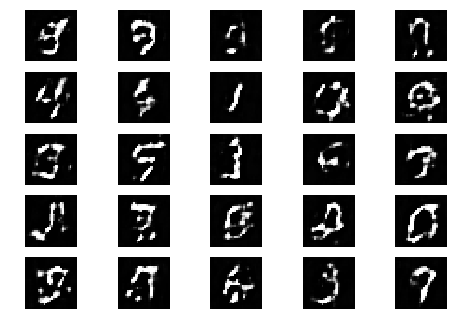

Epoch 1 Batch 51/468 [D loss: 0.000493, acc.: 100.00%] [G loss: 0.000027]
Epoch 1 Batch 52/468 [D loss: 0.001563, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 53/468 [D loss: 0.021045, acc.: 100.00%] [G loss: 0.000037]
Epoch 1 Batch 54/468 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.000030]
Epoch 1 Batch 55/468 [D loss: 0.004700, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 56/468 [D loss: 0.358333, acc.: 87.50%] [G loss: 0.000031]
Epoch 1 Batch 57/468 [D loss: 0.059856, acc.: 100.00%] [G loss: 0.000036]
Epoch 1 Batch 58/468 [D loss: 0.004834, acc.: 100.00%] [G loss: 0.000034]
Epoch 1 Batch 59/468 [D loss: 0.008067, acc.: 100.00%] [G loss: 0.000039]
Epoch 1 Batch 60/468 [D loss: 0.049388, acc.: 96.88%] [G loss: 0.000037]
Epoch 1 Batch 61/468 [D loss: 0.003416, acc.: 100.00%] [G loss: 0.000041]
Epoch 1 Batch 62/468 [D loss: 0.005695, acc.: 100.00%] [G loss: 0.000022]
Epoch 1 Batch 63/468 [D loss: 0.003497, acc.: 100.00%] [G loss: 0.000068]
Epoch 1 Batch 64/468 [D loss: 0.002467, 

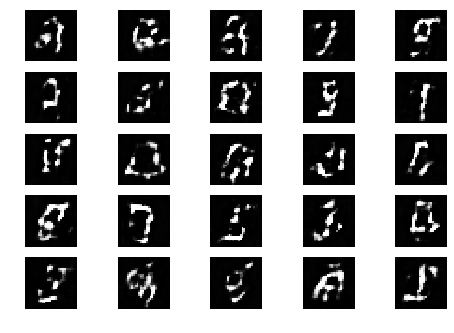

Epoch 1 Batch 101/468 [D loss: 0.001575, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 102/468 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.000052]
Epoch 1 Batch 103/468 [D loss: 0.000126, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 104/468 [D loss: 0.000394, acc.: 100.00%] [G loss: 0.000043]
Epoch 1 Batch 105/468 [D loss: 0.001054, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 106/468 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 107/468 [D loss: 0.000250, acc.: 100.00%] [G loss: 0.000022]
Epoch 1 Batch 108/468 [D loss: 0.000363, acc.: 100.00%] [G loss: 0.000025]
Epoch 1 Batch 109/468 [D loss: 0.001694, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 110/468 [D loss: 0.000351, acc.: 100.00%] [G loss: 0.000040]
Epoch 1 Batch 111/468 [D loss: 0.000303, acc.: 100.00%] [G loss: 0.000033]
Epoch 1 Batch 112/468 [D loss: 0.000794, acc.: 100.00%] [G loss: 0.000040]
Epoch 1 Batch 113/468 [D loss: 0.003131, acc.: 100.00%] [G loss: 0.000038]
Epoch 1 Batch 114/468 [D 

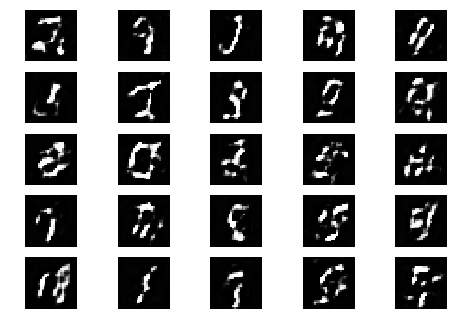

Epoch 1 Batch 151/468 [D loss: 0.027424, acc.: 100.00%] [G loss: 0.000031]
Epoch 1 Batch 152/468 [D loss: 0.001281, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 153/468 [D loss: 0.002751, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 154/468 [D loss: 0.006125, acc.: 100.00%] [G loss: 0.000031]
Epoch 1 Batch 155/468 [D loss: 0.000258, acc.: 100.00%] [G loss: 0.000030]
Epoch 1 Batch 156/468 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 157/468 [D loss: 0.006222, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 158/468 [D loss: 0.000228, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 159/468 [D loss: 0.003388, acc.: 100.00%] [G loss: 0.000059]
Epoch 1 Batch 160/468 [D loss: 0.009109, acc.: 100.00%] [G loss: 0.000040]
Epoch 1 Batch 161/468 [D loss: 0.005430, acc.: 100.00%] [G loss: 0.000022]
Epoch 1 Batch 162/468 [D loss: 0.000477, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 163/468 [D loss: 0.053057, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 164/468 [D 

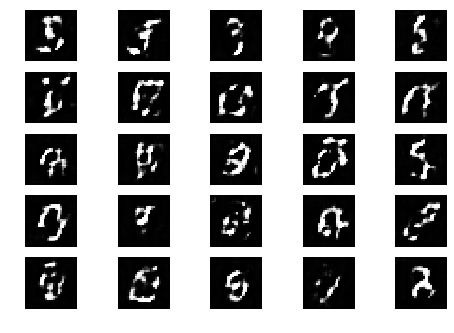

Epoch 1 Batch 201/468 [D loss: 0.000606, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 202/468 [D loss: 0.001520, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 203/468 [D loss: 0.000836, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 204/468 [D loss: 0.000160, acc.: 100.00%] [G loss: 0.000028]
Epoch 1 Batch 205/468 [D loss: 0.009657, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 206/468 [D loss: 0.003175, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 207/468 [D loss: 0.006045, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 208/468 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 209/468 [D loss: 0.000696, acc.: 100.00%] [G loss: 0.000053]
Epoch 1 Batch 210/468 [D loss: 0.000158, acc.: 100.00%] [G loss: 0.000026]
Epoch 1 Batch 211/468 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 212/468 [D loss: 0.000357, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 213/468 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 214/468 [D 

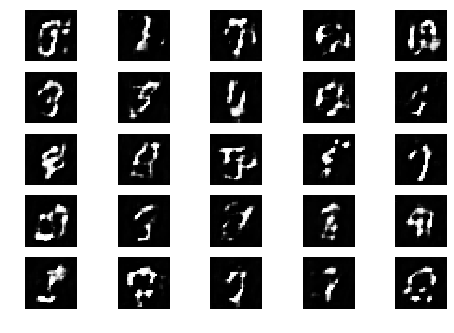

Epoch 1 Batch 251/468 [D loss: 0.000330, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 252/468 [D loss: 0.000609, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 253/468 [D loss: 0.081405, acc.: 93.75%] [G loss: 0.000025]
Epoch 1 Batch 254/468 [D loss: 0.001116, acc.: 100.00%] [G loss: 0.000052]
Epoch 1 Batch 255/468 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.000037]
Epoch 1 Batch 256/468 [D loss: 0.008670, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 257/468 [D loss: 0.001346, acc.: 100.00%] [G loss: 0.000037]
Epoch 1 Batch 258/468 [D loss: 0.000554, acc.: 100.00%] [G loss: 0.000028]
Epoch 1 Batch 259/468 [D loss: 0.000445, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 260/468 [D loss: 0.004982, acc.: 100.00%] [G loss: 0.000010]
Epoch 1 Batch 261/468 [D loss: 0.003350, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 262/468 [D loss: 0.000773, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 263/468 [D loss: 0.000106, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 264/468 [D l

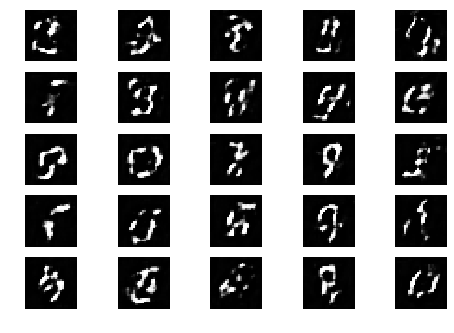

Epoch 1 Batch 301/468 [D loss: 0.000238, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 302/468 [D loss: 0.000394, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 303/468 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000025]
Epoch 1 Batch 304/468 [D loss: 0.000449, acc.: 100.00%] [G loss: 0.000009]
Epoch 1 Batch 305/468 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 306/468 [D loss: 0.000413, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 307/468 [D loss: 0.000137, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 308/468 [D loss: 0.001965, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 309/468 [D loss: 0.000813, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 310/468 [D loss: 0.000108, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 311/468 [D loss: 0.002945, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 312/468 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.000025]
Epoch 1 Batch 313/468 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 314/468 [D 

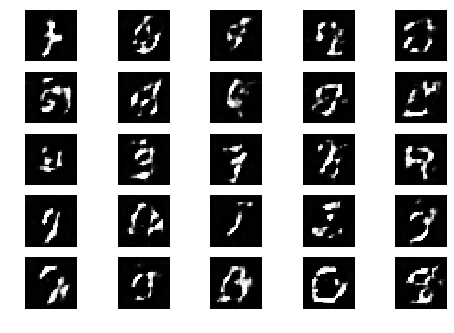

Epoch 1 Batch 351/468 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.000022]
Epoch 1 Batch 352/468 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 353/468 [D loss: 0.003786, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 354/468 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 355/468 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 356/468 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 357/468 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 358/468 [D loss: 0.002946, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 359/468 [D loss: 0.001890, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 360/468 [D loss: 0.000313, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 361/468 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 362/468 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 363/468 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 364/468 [D 

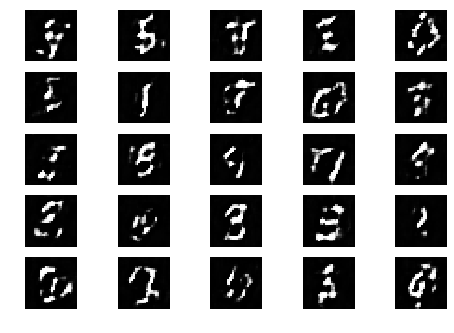

Epoch 1 Batch 401/468 [D loss: 0.000427, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 402/468 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.000022]
Epoch 1 Batch 403/468 [D loss: 0.000600, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 404/468 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 405/468 [D loss: 0.004322, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 406/468 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 407/468 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.000010]
Epoch 1 Batch 408/468 [D loss: 0.055942, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 409/468 [D loss: 0.005167, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 410/468 [D loss: 0.001320, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 411/468 [D loss: 0.000166, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 412/468 [D loss: 0.000151, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 413/468 [D loss: 0.000122, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 414/468 [D 

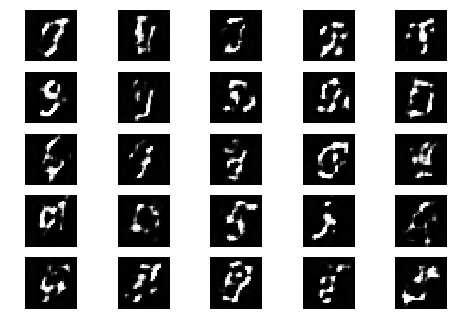

Epoch 1 Batch 451/468 [D loss: 0.000464, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 452/468 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 453/468 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.000010]
Epoch 1 Batch 454/468 [D loss: 0.001966, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 455/468 [D loss: 0.000881, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 456/468 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.000041]
Epoch 1 Batch 457/468 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 458/468 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 459/468 [D loss: 0.000510, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 460/468 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 461/468 [D loss: 0.000245, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 462/468 [D loss: 0.011740, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 463/468 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.000025]
Epoch 1 Batch 464/468 [D 

In [20]:
train(generator1, discriminator1, combined1,
          epochs=1, batch_size=32, save_interval=1)

In [0]:

##encodermodel = build_generator()
##encodermodel.summary()

##noise = np.random.normal(0, 1, (50, 100))
##fake_images = encodermodel.predict(noise)


In [0]:
##encodermodel.predict(inputnoise)